# 1. Problem Statement

# 2. Data: Google Local Data (2021)

**Citation**

**UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining**  
Jiacheng Li, Jingbo Shang, Julian McAuley  
*Annual Meeting of the Association for Computational Linguistics (ACL)*, 2022  
[pdf](https://aclanthology.org/2022.acl-long.426.pdf)


**Personalized Showcases: Generating Multi-Modal Explanations for Recommendations**  
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley  
*The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR)*, 2023  
[pdf](https://arxiv.org/pdf/2207.00422.pdf)

**Data Source**

The Google Local Dataset offers a comprehensive collection from Google Local (Google Maps), featuring 65,000 restaurants and over 1.77 million reviews, along with 4.43 million images posted by approximately 1.01 million users. It contains detailed information such as geographical location, business category,
opening status, price levels, and average ratings for each restaurant. This multi-modal dataset
includes textual reviews, user-generated images, and various metadata attributes, providing a
comprehensive foundation for analyzing consumer preferences and behaviors in the context of
restaurant recommendations.

For our project, we decided to focus on the resturants in Massachusetts, which includes 5,624,944 reviews and 92,520 businesses in metadata.

*Massachusetts 10-cores Review Dataset*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

*Masechusetts Metadata*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

# 3. Data Preprocessing & EDA Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utility import is_english, get_emoji_pattern, merge_df

RERUN_PREPROCESSING = False

In [2]:
df = pd.read_csv("data/data_ma.csv")

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_15244/4290097949.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


### Keep only English reviews

In [3]:
if RERUN_PREPROCESSING:    
    df_filtered = df[-df['text'].isna()].drop_duplicates(
            subset='text', 
            keep='first'
            # The reviews match data/reviews.json
        )[['user_id', 'gmap_id', 'text', 'rating']]

    english_mask = df['text'].apply(is_english)

    df_filtered = df_filtered[english_mask]
    df_filtered.to_csv("data/english_reviews.csv", index=False)

### Remove emoji

In [4]:
df_filtered = pd.read_csv("data/english_reviews.csv")

emoji_pattern = get_emoji_pattern()

has_emoji = df_filtered.text.apply(lambda x: bool(emoji_pattern.search(x)))
print('#Reviews containing emoji:', df_filtered[has_emoji].text.count())

df_filtered['text'] = df_filtered['text'].apply(lambda x: emoji_pattern.sub(r'', x))

#Reviews containing emoji: 15685


### Reduce to extract the k-core for text

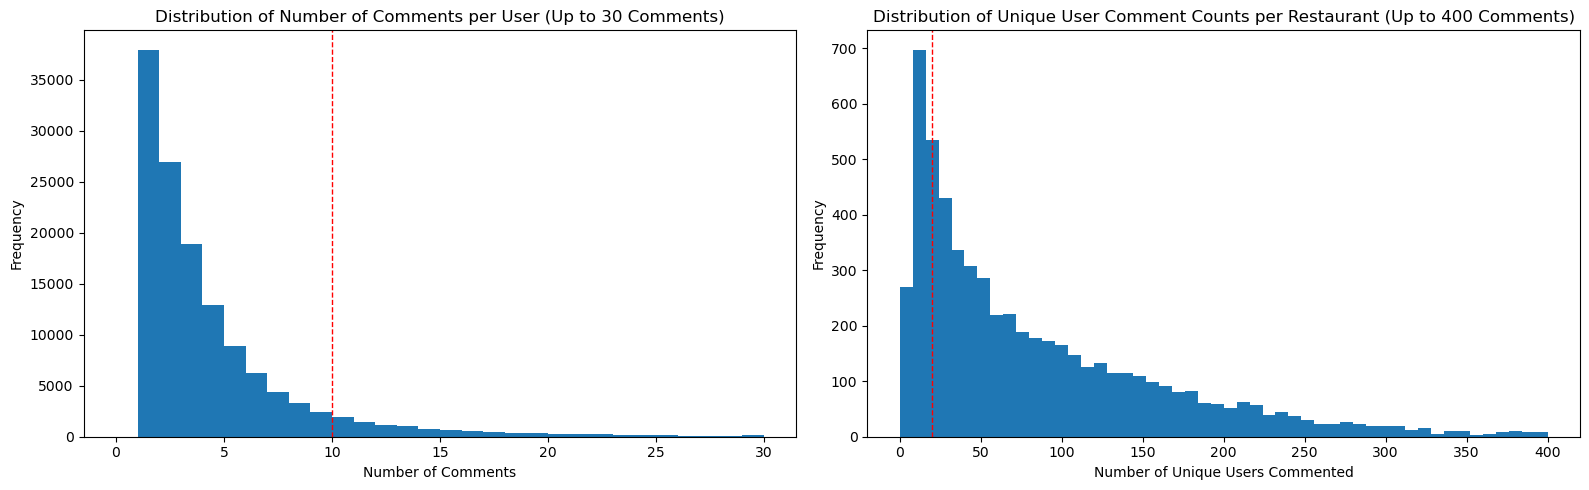

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

comment_counts = df_filtered['user_id'].value_counts()
threshold = 30
axes[0].hist(comment_counts[comment_counts <= threshold], bins=threshold, range=(0, threshold))
axes[0].axvline(x=10, color='r', linestyle='--', linewidth=1)
axes[0].set_title(f'Distribution of Number of Comments per User (Up to {threshold} Comments)')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Frequency')
axes[0].grid(False)

restaurant_user_counts = df_filtered.groupby('gmap_id')['user_id'].nunique()
axes[1].hist(restaurant_user_counts[restaurant_user_counts <= 400], bins=50, range=(0, 400))
axes[1].axvline(x=20, color='r', linestyle='--', linewidth=1)
axes[1].set_title('Distribution of Unique User Comment Counts per Restaurant (Up to 400 Comments)')
axes[1].set_xlabel('Number of Unique Users Commented')
axes[1].set_ylabel('Frequency')
axes[1].grid(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# TODO

In [6]:
if RERUN_PREPROCESSING:  
    # Count the number of comments per gmap_id
    comment_counts = df_filtered['gmap_id'].value_counts().reset_index()
    comment_counts.columns = ['gmap_id', 'comment_count']

    # Filter to include only those gmap_ids with more than 50 comments
    df_filtered = df_filtered.merge(comment_counts, on='gmap_id', how='left')
    df_filtered.to_csv("data/english_reviews.csv", index=False)


    # Filter to include only those user_ids with more than 10 comments
    users_with_more_threshold = comment_counts[comment_counts >= 10].index
    df_filtered = df_filtered[df_filtered['user_id'].isin(users_with_more_threshold)]

    # Replace '\n' or whitespaces with a white space ' '
    df_filtered['text'] = df_filtered['text'].str.replace('\s+', ' ', regex=True)
    concatenated_comments = df_filtered.groupby('user_id')['text'].apply(lambda x: '\n'.join(x))


    #Prepare train and test set for text vectorization
    train_df, test_df = train_test_split(concatenated_comments,
                                        test_size=0.3, random_state=209)

    train_df.to_csv('data/user_concat_text_10_train.csv', sep=';', index=True)
    test_df.to_csv('data/user_concat_text_10_test.csv', sep=';', index=True)

In [7]:
df_cleaned = merge_df(df_filtered)
df_cleaned.to_csv("data/df_cleaned.csv", index=False)

/Users/yuqinbailey/ds2/Restaurant-Rec-Google-Reviews/utility.py:69: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


# 4. Modeling Approach

## 4.1 Baseline Model

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [9]:
df_cleaned = pd.read_csv("data/df_cleaned.csv")[
        ['user_id', 'name_y', 'rating', 'text', 'gmap_id', 'latitude', 'longitude', 'num_of_reviews', 'price', 'avg_rating']
    ]

In [10]:
print(df_cleaned.isnull().any())
print()
print(f"Percentage of missing review text: {df_cleaned['text'].isna().sum()/len(df_cleaned)*100:.2f}%")
print(f"Percentage of reviews with missing values in 'price' column: {df_cleaned['price'].isna().sum()/len(df_cleaned)*100:.2f}%")

user_id           False
name_y            False
rating            False
text              False
gmap_id           False
latitude          False
longitude         False
num_of_reviews    False
price              True
avg_rating        False
dtype: bool

Percentage of missing review text: 0.00%
Percentage of reviews with missing values in 'price' column: 8.33%


In [11]:
df_cleaned.dropna(inplace=True)
# df_cleaned.price.value_counts()
df_cleaned = df_cleaned[~df_cleaned['price'].isin(['₩₩', '₩', '₩₩₩₩', '₩₩₩'])]
df_cleaned.price.value_counts()


price
$$      275818
$       178863
$$$      16701
$$$$      1993
Name: count, dtype: int64

In [12]:
df_cleaned.dropna(inplace=True)
one_hot = pd.get_dummies(df_cleaned['price'])
df_cleaned = pd.concat([df_cleaned, one_hot], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop(['rating','text','name_y','price','user_id','gmap_id'], axis=1), 
                                                    df_cleaned[['rating']], 
                                                    test_size=0.3, random_state=209)

In [13]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
pred1 = model1.predict(X_test)
# rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
mse = mean_squared_error(y_test, pred1)  
rmse = np.sqrt(mse) 
print(f'content-based rmse = {rmse:.4f}')

content-based rmse = 1.1132


In [15]:
feature_importance = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

                Importance
avg_rating        0.948077
$                 0.010282
num_of_reviews    0.010058
longitude         0.008432
$$                0.007501
latitude          0.007239
$$$               0.004666
$$$$              0.003745


## 4.2 Incorperating Review Embeddings (Text-based)

In [16]:
from utility import get_similar_users_avg_rating, merge_df

RERUN_EMBED = False

In [17]:
train_df = pd.read_csv('data/user_concat_text_10_train.csv', sep=';')

In [18]:
df_filtered = pd.read_csv("data/english_reviews.csv")
df_cleaned = merge_df(df_filtered)

/Users/yuqinbailey/ds2/Restaurant-Rec-Google-Reviews/utility.py:69: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


### 4.2.4 Large Language Model (BERT)

In [19]:
if RERUN_EMBED:
    import torch
    from transformers import BertModel, BertTokenizer

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def generate_embedding(input_text):
        input_ids = tokenizer.encode_plus(input_text, 
                                        add_special_tokens=True, 
                                        return_tensors="pt", 
                                        truncation=True,
                                        max_length=512,
                                        padding='max_length')  # Adjust max_length
        # Move inputs to GPU
        input_ids = input_ids.to(device)
        with torch.no_grad():
            # Move model to GPU
            model.to(device)
            outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
            embeddings = outputs.last_hidden_state  # Extract the embeddings
        return embeddings
    
    train_df['bert_embedding'] = train_df['text'].apply(generate_embedding)
    train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.to('cpu').numpy() if isinstance(x, torch.Tensor) else x)
    train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.reshape(512, 768))

    test_df['bert_embedding'] = test_df['text'].progress_apply(generate_embedding)
    test_df['bert_embedding'] = test_df['bert_embedding'].apply(lambda x: x.to('cpu').numpy() if isinstance(x, torch.Tensor) else x)
    test_df['bert_embedding'] = test_df['bert_embedding'].apply(lambda x: x.reshape(512, 768))

    train_df.to_csv('data/user_concat_text_10_train.csv', sep=';', index=False)
    test_df.to_csv('data/user_concat_text_10_test.csv', sep=';', index=False)

In [20]:
if RERUN_EMBED:
    df_cleaned['bert_rating'] = df_cleaned.apply(lambda row: get_similar_users_avg_rating(
        train_df, df_filtered, row['user_id'], row['gmap_id']), axis=1)

    # Replace None with pd.nan in 'bert_rating' column
    df_cleaned['bert_rating'].replace({None: pd.nan}, inplace=True)

# 5. Results